In [1]:
# import nedded libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.exposure
from numpy import asarray
import math
from skimage.measure import regionprops_table, label
import pandas as pd
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# arrays to save image in each step
brigthened = []
contrast = []
removed_noise = []
blur = []
hsv = []
masked = []
contours = []
temp_x = []
temp_y = []

In [3]:
# increase brightness
def brighten_img(img):
    global brigthened
    # increasing brightness  
    img_brightned = skimage.exposure.rescale_intensity(img,in_range=(1,40), out_range=(0,180))
    
    # add image to array
    brigthened.append(img_brightned)
    
    return img_brightned



In [4]:
# increase contrast
def increase_contrast(img_brightned):
    
    global contrast
    
    # converting to LAB color space
    lab= cv2.cvtColor(img_brightned.astype(np.uint8), cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB to BGR 
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # add image to array
    contrast.append(enhanced_img)
    
    return enhanced_img

In [5]:
# remove noise
def remove_noise(enhanced_img):
    global removed_noise
    
    noiseless_image_colored = cv2.fastNlMeansDenoisingColored(enhanced_img,None,10,10,5,10) 
    
    # add image to array
    removed_noise.append(noiseless_image_colored)
    
    return noiseless_image_colored

In [6]:
def find_biggest_contour(image):
    
    # Find contours from the mask
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    biggest_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros(image.shape, np.uint8)
    
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    
    return mask



def segmentation(noiseless_image_colored):
    global blur
    global hsv
    global masked
    global contours
    
    image_blur = cv2.GaussianBlur(noiseless_image_colored, (7, 7), 0)

    # convert to hsv
    image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)

    # lower bound and upper bound for color 
    lower_bound = np.array([50, 50, 100])
    upper_bound = np.array([255, 255, 255])

    # find the colors within the boundaries 
    mask = cv2.inRange(image_blur_hsv, lower_bound, upper_bound)

    # removing extra objects by getting only desired areas
    masked_img = find_biggest_contour(mask)

    # adding images to arrays
    blur.append(image_blur)
    hsv.append(image_blur_hsv)
    masked.append(mask)
    contours.append(masked_img)
    
    return masked_img



In [7]:
# arrays 
images = [] # array for images read from Dataset_Pre folder 
output = [] # array for images resulted from segmentation
images2 = [] # array for images read from Segmentation_Ground_Truth folder 
iou_scores = [] # array for iou score of each image

In [8]:
def run(path,path2,start,end,start_output,end_output):
    global images
    global output
    global images2
    
    # reading images and adding them to images array
    for i in range (start,end):
        x = str(i+1)
        n = cv2.imread(path+x+".bmp")
        images.append(n)


    # adding segmented images to output array
    for i in range(start_output,end_output):
        # increase brightness
        img_brightned = brighten_img(images[i])
        # increase contrast
        img_enhanced = increase_contrast(img_brightned)
        # remove noise
        img_noiseless= remove_noise(img_enhanced)
        # segmenation process
        mask = segmentation(img_noiseless)
        output.append(mask)


    

    # reading images and adding them to images2 array
    for i in range (start,end):
        x = str(i+1)
        img = cv2.imread(path2+x+".bmp")
        # image is converted to gray 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images2.append(asarray(gray))
        
    # adding iou of each image to array  
    for i in range(start_output,end_output):
        intersection = np.logical_and(images2[i], output[i])
        union = np.logical_or(images2[i], output[i])
        iou_score = np.sum(intersection) / np.sum(union)
        iou_scores.append(iou_score)   

   


In [9]:
def get_iou():
    total = 0
    global iou_scores
    for i in range(len(iou_scores)):
        total = total + iou_scores[i]

    avg = total / len(iou_scores)

    return avg

In [10]:
def main():
    # baso
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/baso/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/baso/',0,53,0,53)
    # eosi
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/eosi/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/eosi/',0,39,53,92)
    # lymp
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/lymp/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/lymp/',0,52,92,144)
    # mixt
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/mixt/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/mixt/',0,8,144,152)
    # mono
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/mono/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/mono/',0,48,152,200)
    # neut
    run('C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Dataset_Pre/output_pre/neut/','C:/Users/mariam/Desktop/semster 7/digital image processing/12th project/Segmentation_Ground_Truth/output/neut/',0,50,200,250)
    # iou
    print("IOU for all images : "+str(get_iou()))
    

In [11]:
main()

IOU for all images : 0.7458297282150945


In [12]:
def fourier_descriptor(x, y):
    complex_ = np.array([complex(i, j) for i, j in zip(x, y)])
    F = np.fft.fft(complex_)

    F_positive = abs(F)

    scale = abs(F[1])
    F_trunc = F_positive[1:11]
    F_final = F_trunc / scale
    return F_final



In [13]:
# dataframe
df = pd.DataFrame()
# array for circularity
circularity = []  
# descriptor
temp_desc = []
global temp_x
global temp_y

for i in range (0,250):
    bw = output[i] > 28
    label_img = label(bw)

    props_dict = regionprops_table(label_img, output[i],properties=['label', 'area','perimeter', 'eccentricity','moments_hu'])

    features_table = [[] for label in props_dict['label']]
    for prop, values in props_dict.items():
        for i, value in enumerate(values):
            features_table[i].append(value)
            
    df = pd.concat([df,pd.DataFrame(props_dict)],ignore_index=True)

# circularity & descriptor
for i in range (0,250):
    # circularity
    circularity.append((4* math.pi * (df.loc[i,"area"]) / math.pow(df.loc[i,"perimeter"],2)))
     
    # descriptor   
    # contours
    contours, hierarchy = cv2.findContours(output[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    temp_x.append(contours[0][:, 0][:, 0])
    temp_y.append(contours[0][:, 0][:, 1])
    
    temp_desc.append(fourier_descriptor(temp_x[i], temp_y[i]))





In [14]:
df["Class"] = ""

# baso
for i in range (0,53):   
    df.loc[i,"Class"] = "baso"
# eosi
for i in range (53,92):   
    df.loc[i,"Class"] = "eosi"
# lymp
for i in range (92,144):   
    df.loc[i,"Class"] = "lymp"        

# mixt
for i in range (144,152):   
    df.loc[i,"Class"] = "mixt"   
    
# mono
for i in range (152,200):   
    df.loc[i,"Class"] = "mono"
    
# neut
for i in range (200,250):   
    df.loc[i,"Class"] = "neut"   
    
df.insert(3,"circularity",circularity,True)
df.insert(4,"descriptor",temp_desc,True)


In [15]:
df

,label,area,perimeter,circularity,descriptor,eccentricity,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,Class
0,1,5139,292.492424,0.754848,"[1.0, 0.4472762487436118, 0.5946439626574913, ...",0.620881,0.169070,0.001630,0.000293,5.344022e-06,1.112478e-10,1.532945e-07,1.797938e-10,baso
1,1,4459,282.492424,0.702156,"[1.0, 0.5902189035820548, 0.25362895153948317,...",0.745251,0.181181,0.004852,0.000460,1.563811e-05,1.196874e-10,-2.444880e-07,1.320302e-09,baso
2,1,6872,491.658946,0.357244,"[1.0, 1.1633147184125723, 0.4564513023092204, ...",0.454294,0.209274,0.000580,0.005682,2.801748e-04,-1.390824e-07,-6.531526e-07,3.250018e-07,baso
3,1,3196,246.214249,0.662507,"[1.0, 0.12659984724128504, 0.14683678285807494...",0.657533,0.169344,0.002181,0.000095,4.175539e-06,-8.015315e-11,-1.950047e-07,2.239497e-11,baso
4,1,4978,273.078210,0.838862,"[1.0, 0.3646060986775308, 0.11820223611317283,...",0.201124,0.159748,0.000011,0.000012,5.228641e-09,-1.019801e-15,-9.611633e-12,-8.361995e-16,baso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,2030,220.894444,0.522801,"[1.0, 3.256238966597567, 2.647860851751606, 0....",0.494002,0.188890,0.000689,0.000432,5.225314e-05,-6.670004e-09,1.367839e-06,4.139514e-09,neut
246,1,1782,235.279221,0.404530,"[1.0, 0.37674393434706555, 0.07431072258242788...",0.866818,0.295571,0.031635,0.009910,1.953390e-03,6.422425e-06,1.867916e-04,-5.711340e-06,neut
247,1,1218,219.379726,0.318027,"[1.0, 0.46053236797671687, 0.3034549423805518,...",0.893043,0.388034,0.066233,0.012647,1.252934e-03,-2.984979e-06,-1.747326e-04,3.995611e-06,neut
248,1,1801,266.592929,0.318439,"[1.0, 0.23791813680574309, 0.28975433698097103...",0.915412,0.358847,0.066967,0.001845,6.275225e-04,2.650057e-07,1.467467e-05,6.211333e-07,neut


In [16]:
# input
X = df.drop(columns = ['Class','label','descriptor'])
# target
y = df['Class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2)

In [18]:
clf = svm.SVC(kernel="linear")
clf.fit(X_train,y_train)

SVC(kernel='linear')

In [19]:
predictions = clf.predict(X_test)
print(predictions[:10])
print("Accuracy: {}%".format(clf.score(X_test, y_test) * 100 ))

['baso' 'mono' 'mixt' 'neut' 'eosi' 'lymp' 'mixt' 'baso' 'neut' 'neut']
Accuracy: 62.0%


In [21]:
from mlxtend.evaluate import accuracy_score

std_acc = accuracy_score(y_test, predictions)
bin_acc = accuracy_score(y_test, predictions, method='binary', pos_label="baso")
bin_acc2 = accuracy_score(y_test, predictions, method='binary', pos_label="eosi")
bin_acc3 = accuracy_score(y_test, predictions, method='binary', pos_label="lymp")
bin_acc4 = accuracy_score(y_test, predictions, method='binary', pos_label="mixt")
bin_acc5 = accuracy_score(y_test, predictions, method='binary', pos_label="mono")
bin_acc6 = accuracy_score(y_test, predictions, method='binary', pos_label="neut")

print(f'Standard accuracy: {std_acc*100:.2f}%')
print(f'Class Baso accuracy: {bin_acc*100:.2f}%')
print(f'Class Eosi accuracy: {bin_acc2*100:.2f}%')
print(f'Class Lymp accuracy: {bin_acc3*100:.2f}%')
print(f'Class Mixt accuracy: {bin_acc4*100:.2f}%')
print(f'Class Mono accuracy: {bin_acc5*100:.2f}%')
print(f'Class Neut accuracy: {bin_acc6*100:.2f}%')

Standard accuracy: 62.00%
Class Baso accuracy: 78.00%
Class Eosi accuracy: 86.00%
Class Lymp accuracy: 92.00%
Class Mixt accuracy: 94.00%
Class Mono accuracy: 80.00%
Class Neut accuracy: 94.00%


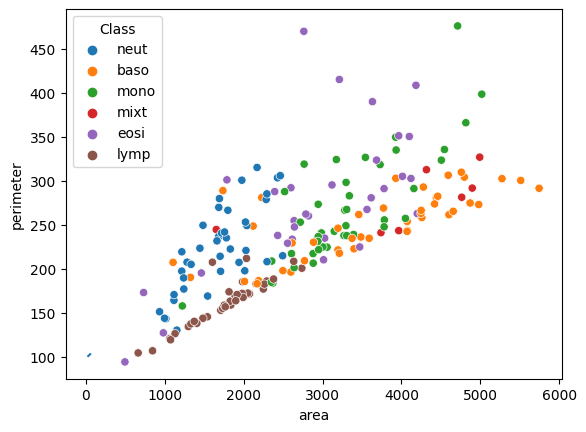

In [22]:
import numpy as np
from seaborn import scatterplot
w = clf.coef_[0]
b = clf.intercept_[0]
x_visual = np.linspace(32,57)
y_visual = -(w[0] / w[1]) * x_visual - b / w[1]

scatterplot(data = X_train, x='area', y='perimeter', hue=y_train)
plt.plot(x_visual, y_visual)
plt.show()